[Reference Tutorial: pennylane](https://pennylane.ai/qml/demos/tutorial_variational_classifier/)

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

np.random.seed(0)

In [2]:
dev = qml.device("default.qubit") #create a device to run the quantum circuit

## Functions


In [3]:
def square_loss(labels, predictions):
    """Calculate the mean square loss between true labels and predictions.

    Args:
        labels (array): Array of true labels.
        predictions (array): Array of predicted labels.

    Returns:
        float: Mean square loss.
    """
    return np.mean((labels - predictions) ** 2)

def accuracy(labels, predictions):
    """Calculate the accuracy between true labels and predictions.

    Args:
        labels (array): Array of true labels.
        predictions (array): Array of predicted labels.

    Returns:
        float: Accuracy.
    """
    res_accuracy = sum(abs(label - prediction) < 1e-5 
               for label, prediction in zip(labels, predictions))
            
    res_accuracy = res_accuracy / len(labels)

    return res_accuracy

In [4]:
def get_angles(x):
    """Data loading part 1: Calculate the angles for state preparation.
        according to https://arxiv.org/pdf/quant-ph/0407010.pdf

    Args:
        x (array): Array of input features of size 4.

    Returns:
        array: Array of angles.
    """
    # output = np.zeros(5)
    # output[:4] = x/np.linalg.norm(x)
    # return output

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_preparation(a):
    """Data loading part 2: Encodes 5 input features into the amplitudes of a quantum state.
        according to https://arxiv.org/pdf/quant-ph/0407010.pdf

    Args:
        a (array): Array of angles from get_angles(theta).
    """
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

    # qml.Rot(a[0], a[1], a[2], wires=0)
    # qml.CNOT(wires=[0, 1])
    # qml.Rot(a[3], a[4], 0, wires=1)

def layer(layer_weights):
    """Applies a single layer of rotations followed by a CNOT gate.

    Args:
        layer_weights (array): Array of rotation angles for the layer of shape (2, 3).
    """
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(weights, x):
    """Defines the quantum circuit.

    Args:
        weights (array): Array of weights for the circuit
        x (array): Array of input features.

    Returns:
        float: Expectation value of the Pauli-Z operator.
    """
    state_preparation(x)
    qml.Barrier(only_visual=True)

    for layer_weights in weights:
        layer(layer_weights)

    qml.Barrier(only_visual=True)
    
    return qml.expval(qml.PauliZ(0))

## Testing the code

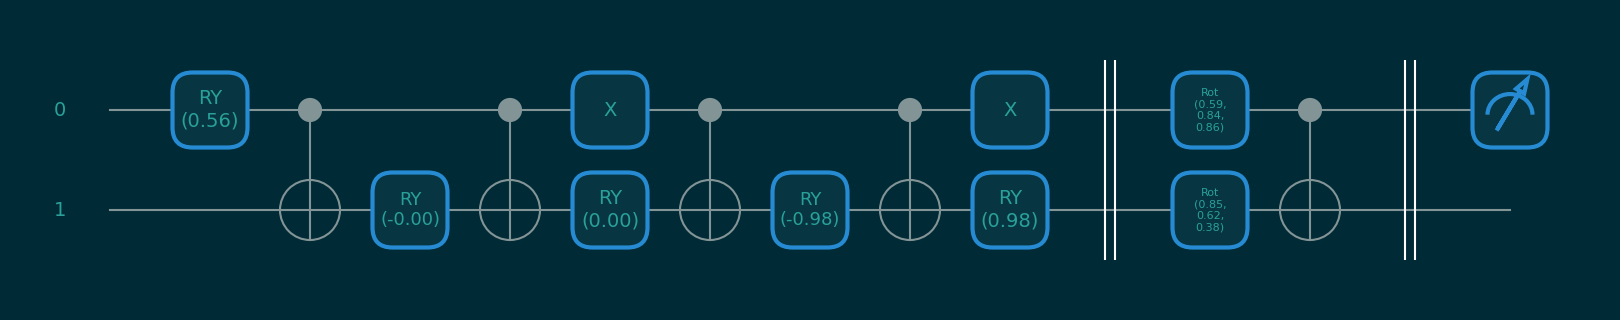

In [5]:
# Define the input vector
input_data = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)

# Get the angles for state preparation
angles_for_state_preparation = get_angles(input_data)

# Define the initial weights
num_layers = 1
dev_weights = 2
weights = np.random.uniform(size=(num_layers, dev_weights, 3)) #3 corresponds to the number of rotation angles in each layer

parameters = (weights, angles_for_state_preparation)

#visualize the circuit
qml.draw_mpl(circuit, style="solarized_dark", decimals=2)(*parameters);

In [6]:
def variational_classifier(weights, bias, x):
    """Defines the variational classifier.

    Args:
        weights (array): Array of weights for the quantum circuit.
        bias (float): Bias term.
        x (array): Array of input features.

    Returns:
        float: Output of the classifier.
    """
    return circuit(weights, x) + bias

def cost(weights, bias, X, Y):
    """Compute the cost function.

    Args:
        weights (array): Array of weights for the quantum circuit.
        bias (float): Bias term.
        X (array): Array of input features.
        Y (array): Array of true labels.

    Returns:
        float: Cost function value.
    """
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

In [7]:

# Define a PennyLane QNode for testing
@qml.qnode(dev)
def test_state_preparation(angles):
    """Test the state preparation."""
    state_preparation(angles)
    return qml.state()

# Get the final state after preparing the quantum state
final_state = test_state_preparation(angles_for_state_preparation)

# Print the results
print("Input data             : ", np.round(input_data, 6))
print("Angles for preparation: ", np.round(angles_for_state_preparation, 6))
print("Final state vector     : ", np.round(np.real(final_state), 6))

if np.allclose(final_state, input_data):
    print("The method correctly prepares the quantum state.")
else:
    print("The method does not prepare the quantum state correctly.")

Input data             :  [0.538968 0.795036 0.278265 0.      ]
Angles for preparation:  [ 0.563975 -0.        0.       -0.975046  0.975046]
Final state vector     :  [ 0.538968  0.795036  0.278265 -0.      ]
The method correctly prepares the quantum state.


## Data loading and preprocessing


In [8]:
data = np.loadtxt("iris_dataset.txt")
features = data[:, 0:2]

# Display original feature sample
print(f"First feature sample (original): {features[0]}")

# Pad the feature vectors to size 2^2=4 with constant values
padding = np.ones((len(features), 2)) * 0.1
padded_features = np.c_[features, padding]
print(f"First feature sample (padded): {padded_features[0]}")

# Normalize each input feature
norms = np.sqrt(np.sum(padded_features**2, axis=-1))
normalized_features = (padded_features.T / norms).T
print(f"First feature sample (normalized): {normalized_features[0]}")

# Extract angles for state preparation as features
angles_features = np.array([get_angles(x) for x in normalized_features], requires_grad=False)
print(f"First features sample (angles): {angles_features[0]}")

# Extract labels
labels = data[:, -1]

First feature sample (original): [0.4  0.75]
First feature sample (padded): [0.4  0.75 0.1  0.1 ]
First feature sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample (angles): [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


In [9]:
def plot_preprocessing_stages(features, normalized_features, angles_features, labels):
    """
    Plot different stages of preprocessing in subplots.

    Args:
        features (array-like): Original features.
        normalized_features (array-like): Normalized features.
        angles_features (array-like): Features converted to angles.
        labels (array-like): Labels corresponding to the features.
    """

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Original data
    axs[0].scatter(features[:, 0][labels == 1], features[:, 1][labels == 1], c="b", marker="o", ec="k")
    axs[0].scatter(features[:, 0][labels == -1], features[:, 1][labels == -1], c="r", marker="o", ec="k")
    axs[0].set_title("Original data")

    # Padded and normalized data
    dim1 = 0
    dim2 = 1
    axs[1].scatter(normalized_features[:, dim1][labels == 1], normalized_features[:, dim2][labels == 1],
                   c="b", marker="o", ec="k", label="class 1")
    axs[1].scatter(normalized_features[:, dim1][labels == -1], normalized_features[:, dim2][labels == -1],
                   c="r", marker="o", ec="k", label="class -1")
    axs[1].set_title(f"Padded and normalized data (dims {dim1} and {dim2})")

    axs[1].legend()

    # Feature vectors
    dim1 = 0
    dim2 = 3
    axs[2].scatter(angles_features[:, dim1][labels == 1], angles_features[:, dim2][labels == 1],
                   c="b", marker="o", ec="k", label="class 1")
    axs[2].scatter(angles_features[:, dim1][labels == -1], angles_features[:, dim2][labels == -1],
                   c="r", marker="o", ec="k", label="class -1")
    
    axs[2].legend()
    axs[2].set_title(f"Angles features (dims {dim1} and {dim2})")

    plt.show()


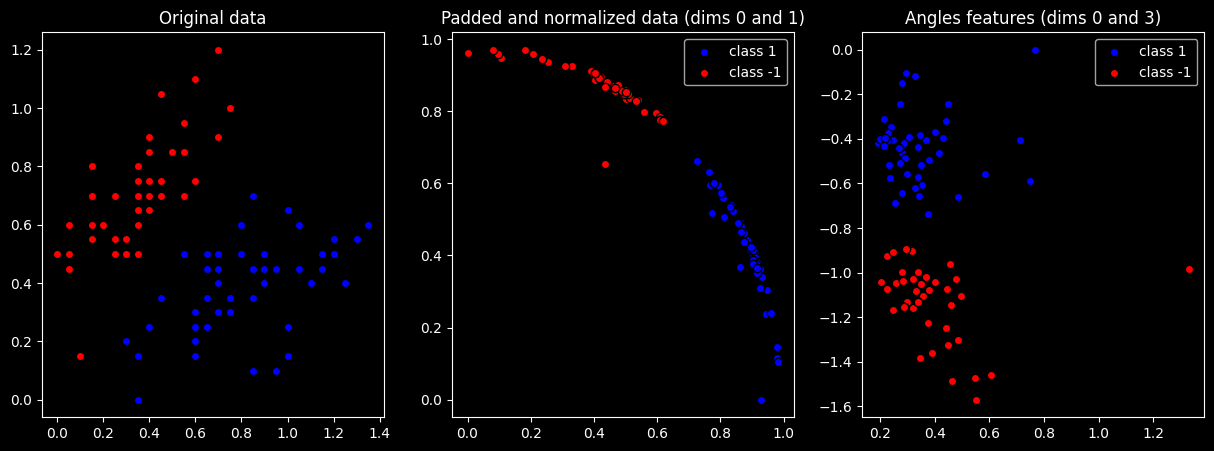

In [10]:
# Assuming the variables are defined as follows:
# features, normalized_features, angles_features, labels

# Call the function with the provided variables
plot_preprocessing_stages(features, normalized_features, angles_features, labels)


In [11]:

# Split data into training and validation sets
np.random.seed(0)
num_data = len(labels)
num_train = int(0.75 * num_data)
indices = np.random.permutation(range(num_data))
train_indices = indices[:num_train]
val_indices = indices[num_train:]

train_features = angles_features[train_indices]
train_labels = labels[train_indices]
val_features = angles_features[val_indices]
val_labels = labels[val_indices]

# We need these later for plotting
train_original = features[train_indices]
val_original = features[val_indices]


## Optimization

In [12]:
# Optimization
num_qubits = 2
num_layers = 6  #try changing the number of layers to see how the result changes

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
bias_init = np.array(0.0)

# Initialize optimizer
optimizer = qml.optimize.NesterovMomentumOptimizer(0.01)
batch_size = 5

# Train the variational classifier
weights = weights_init
bias = bias_init
list_cost_values = []
list_train_accuracy = []
list_val_accuracy = []

for it in range(60):
    # Update the weights by one optimizer step
    batch_indices = np.random.randint(0, num_train, size=(batch_size,))
    train_feats_batch = train_features[batch_indices]
    train_labels_batch = train_labels[batch_indices]
    weights, bias, _, _ = optimizer.step(cost, weights, bias, train_feats_batch, train_labels_batch)

    # Compute predictions on train and validation set
    train_predictions = np.sign(variational_classifier(weights, bias, train_features.T))
    val_predictions = np.sign(variational_classifier(weights, bias, val_features.T))

    # Compute accuracy on train and validation set
    train_accuracy = accuracy(train_labels, train_predictions)
    val_accuracy = accuracy(val_labels, val_predictions)

    # Store the cost and accuracies for later plotting
    list_cost_values.append(cost(weights, bias, train_feats_batch, train_labels_batch))
    list_train_accuracy.append(train_accuracy)
    list_val_accuracy.append(val_accuracy)

    # Print training progress
    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, angles_features, labels)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Train Accuracy: {train_accuracy:0.7f} | Validation Accuracy: {val_accuracy:0.7f}"
        )


Iter:     2 | Cost: 1.6589456 | Train Accuracy: 0.4800000 | Validation Accuracy: 0.5600000
Iter:     4 | Cost: 1.2054273 | Train Accuracy: 0.4933333 | Validation Accuracy: 0.5600000
Iter:     6 | Cost: 0.9740740 | Train Accuracy: 0.4933333 | Validation Accuracy: 0.7200000
Iter:     8 | Cost: 0.9660872 | Train Accuracy: 0.6400000 | Validation Accuracy: 0.6400000
Iter:    10 | Cost: 0.9569019 | Train Accuracy: 0.6000000 | Validation Accuracy: 0.6000000
Iter:    12 | Cost: 0.9445863 | Train Accuracy: 0.4933333 | Validation Accuracy: 0.7200000
Iter:    14 | Cost: 1.0339978 | Train Accuracy: 0.4800000 | Validation Accuracy: 0.5600000
Iter:    16 | Cost: 1.0774217 | Train Accuracy: 0.4933333 | Validation Accuracy: 0.5600000
Iter:    18 | Cost: 0.9984426 | Train Accuracy: 0.4800000 | Validation Accuracy: 0.5600000
Iter:    20 | Cost: 0.8975279 | Train Accuracy: 0.5600000 | Validation Accuracy: 0.7600000
Iter:    22 | Cost: 0.8451699 | Train Accuracy: 0.6400000 | Validation Accuracy: 0.6400000

## Plot cost, train, and val accuracy.

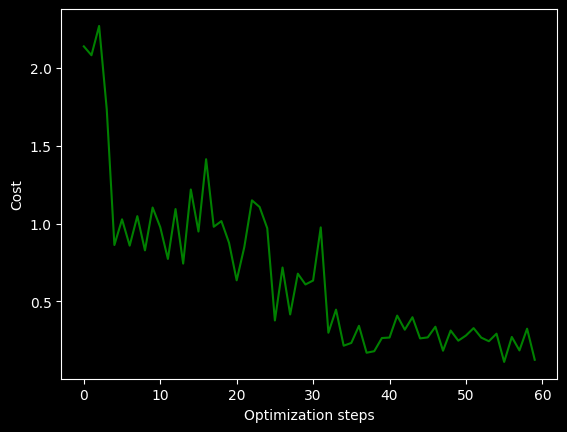

In [13]:
plt.figure()
plt.plot(list_cost_values, "g", label="Cost")
plt.ylabel("Cost")
plt.xlabel("Optimization steps")
plt.show()

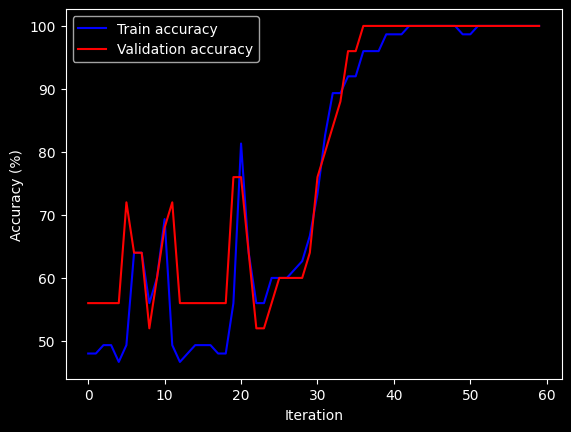

In [14]:
plt.figure()
plt.plot(np.array(list_train_accuracy)*100, "b", label="Train accuracy")
plt.plot(np.array(list_val_accuracy)*100, "r", label="Validation accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

In [15]:
def plot_decision_regions(training_data, training_labels, validation_data, validation_labels, trained_weights, trained_bias):
    # Set colormap for decision regions
    colormap = plt.cm.RdBu

    # Create grid for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
    decision_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    # Preprocess grid points similar to data inputs
    padding = 0.1 * np.ones((len(decision_grid), 2))
    decision_grid = np.c_[decision_grid, padding]  # Pad each input
    normalization = np.sqrt(np.sum(decision_grid**2, -1))
    decision_grid = (decision_grid.T / normalization).T  # Normalize each input
    features_grid = np.array([get_angles(point) for point in decision_grid])  # Angles are new features

    # Predictions for decision regions
    predictions_grid = variational_classifier(trained_weights, trained_bias, features_grid.T)
    decision_regions = np.reshape(predictions_grid, xx.shape)

    # Plot decision regions
    levels = np.arange(-1, 1.1, 0.1)
    contour = plt.contourf(xx, yy, decision_regions, levels=levels, cmap=colormap, alpha=0.8, extend="both")
    plt.contour(xx, yy, decision_regions, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(contour, ticks=[-1, 0, 1])

    # Plot data
    for color, label in zip(["b", "r"], [1, -1]):
        train_data_x = training_data[:, 0][training_labels == label]
        train_data_y = training_data[:, 1][training_labels == label]
        plt.scatter(train_data_x, train_data_y, c=color, marker="o", ec="k", label=f"class {label} train")

        validation_data_x = validation_data[:, 0][validation_labels == label]
        validation_data_y = validation_data[:, 1][validation_labels == label]
        plt.scatter(validation_data_x, validation_data_y, c=color, marker="^", ec="k", label=f"class {label} validation")

    plt.legend()
    plt.show()

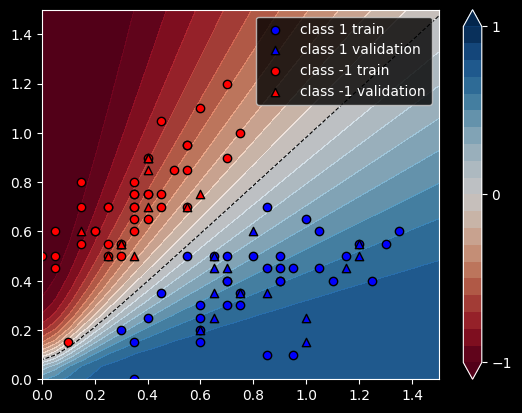

In [16]:
# # Plot decision regions and data points
# plot_decision_regions(train_original, train_labels, val_original, val_labels, weights, bias)

plot_decision_regions(training_data=train_original,
                      training_labels=train_labels,
                      validation_data=val_original,
                      validation_labels=val_labels,
                      trained_weights=weights,
                      trained_bias=bias)

# Your Turn: 
- Change the number of layers.
- Change the code in the layer function which is your ansatz.

How does the result compare?

In [17]:
stop

NameError: name 'stop' is not defined

## Set up the hybrid jobs on AWS braket

In [ ]:
from braket.aws import AwsDevice
from braket.jobs import hybrid_job
from braket.devices import Devices
from braket.tracking import Tracker
from braket.jobs.metrics import log_metric

#### AWS Device

In [ ]:
DEVICE_ARN = Devices.Amazon.SV1
# DEVICE_ARN = Devices.Rigetti.AspenM3

DEVICE_ARN.value

'arn:aws:braket:::device/quantum-simulator/amazon/sv1'

In [ ]:
aws_device = AwsDevice(DEVICE_ARN)

aws_device.is_available

True

In [ ]:
aws_device.queue_depth()

QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')

In [ ]:
aws_device.queue_depth().jobs

'0'

### Hybrid Job

In [ ]:
# @hybrid_job(device=DEVICE_ARN, local=True)
# @hybrid_job(device=DEVICE_ARN)

@hybrid_job(device="local:pennylane/default.qubit")
def iris_classification(qubits_count=2,
                        shots_count=1000,
                        repititions=20, 
                        ):
    
    braket_cost_tracker = Tracker().start()
    
    # QML Device
    
    # qml_device = qml.device("braket.aws.qubit", 
    #                         device_arn=DEVICE_ARN.value, 
    #                         wires=qubits_count, 
    #                         shots=shots_count)    
    
    dev = qml.device("default.qubit", 
                            wires=qubits_count)
    
    def square_loss(labels, predictions):
        """Calculate the mean square loss between true labels and predictions.

        Args:
            labels (array): Array of true labels.
            predictions (array): Array of predicted labels.

        Returns:
            float: Mean square loss.
        """
        loss = 0
        
        for label, prediction in zip(labels, predictions):
            loss = loss + (label - prediction) ** 2

        loss = loss / len(labels)
        
        return loss

    def accuracy(labels, predictions):
        """Calculate the accuracy between true labels and predictions.

        Args:
            labels (array): Array of true labels.
            predictions (array): Array of predicted labels.

        Returns:
            float: Accuracy.
        """
        res_accuracy = sum(abs(label - prediction) < 1e-5 
                for label, prediction in zip(labels, predictions))
                
        res_accuracy = res_accuracy / len(labels)

        return res_accuracy

    def get_angles(x):
        """Calculate the angles for state preparation.

        Args:
            x (array): Array of input features.

        Returns:
            array: Array of angles.
        """
        beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
        beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
        beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

        return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

    def state_preparation(a):
        """Encodes 5 input features into the amplitudes of a quantum state.

        Args:
            a (array): Array of angles from get_angles(theta).
        """
        qml.RY(a[0], wires=0)

        qml.CNOT(wires=[0, 1])
        qml.RY(a[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[2], wires=1)

        qml.PauliX(wires=0)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[3], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[4], wires=1)
        qml.PauliX(wires=0)

    def layer(layer_weights):
        """Applies a single layer of rotations followed by a CNOT gate.

        Args:
            layer_weights (array): Array of rotation angles for the layer.
        """
        for wire in range(2):
            qml.Rot(*layer_weights[wire], wires=wire)
        qml.CNOT(wires=[0, 1])

    @qml.qnode(dev)
    def circuit(weights, x):
        """Defines the quantum circuit.

        Args:
            weights (array): Array of weights for the circuit.
            x (array): Array of input features.

        Returns:
            float: Expectation value of the Pauli-Z operator.
        """
        state_preparation(x)

        for layer_weights in weights:
            layer(layer_weights)

        return qml.expval(qml.PauliZ(0))

    def variational_classifier(weights, bias, x):
        """Defines the variational classifier.

        Args:
            weights (array): Array of weights for the quantum circuit.
            bias (float): Bias term.
            x (array): Array of input features.

        Returns:
            float: Output of the classifier.
        """
        return circuit(weights, x) + bias

    def cost(weights, bias, X, Y):
        """Compute the cost function.

        Args:
            weights (array): Array of weights for the quantum circuit.
            bias (float): Bias term.
            X (array): Array of input features.
            Y (array): Array of true labels.

        Returns:
            float: Cost function value.
        """
        predictions = variational_classifier(weights, bias, X.T)
        return square_loss(Y, predictions)
    

    # Optimization
    num_qubits = 2
    num_layers = 6

    weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
    bias_init = np.array(0.0)

    # Initialize optimizer
    optimizer = qml.optimize.NesterovMomentumOptimizer(0.01)
    batch_size = 5

    # Train the variational classifier
    weights = weights_init
    bias = bias_init

    list_cost_values = []
    list_train_accuracy = []
    list_val_accuracy = []

    for iter in range(repititions):
        # Update the weights by one optimizer step
        batch_indices = np.random.randint(0, num_train, size=(batch_size,))
        train_feats_batch = train_features[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        weights, bias, _, _ = optimizer.step(cost, weights, bias, train_feats_batch, train_labels_batch)

        # Compute predictions on train and validation set
        train_predictions = np.sign(variational_classifier(weights, bias, train_features.T))
        val_predictions = np.sign(variational_classifier(weights, bias, val_features.T))

        # Compute accuracy on train and validation set
        train_accuracy = accuracy(train_labels, train_predictions)
        val_accuracy = accuracy(val_labels, val_predictions)

        
        _cost = cost(weights, bias, angles_features, labels)
        print(
            f"Iter: {iter + 1:5d} | Cost: {_cost:0.7f} | "
            f"Train Accuracy: {train_accuracy:0.7f} | Validation Accuracy: {val_accuracy:0.7f}"
        )
        
        list_cost_values.append(_cost.item())
        list_train_accuracy.append(train_accuracy.item())
        list_val_accuracy.append(val_accuracy.item())

        # Log Metrics
        braket_task_cost = float(
            braket_cost_tracker.qpu_tasks_cost() + 
            braket_cost_tracker.simulator_tasks_cost()
        )
        
        log_metric(metric_name="braket_cost", 
                   value=braket_task_cost, 
                   iteration_number=iter)
        
        log_metric(metric_name="cost", 
                   value=_cost,
                   iteration_number=iter)
        
        log_metric(metric_name="train_accuracy", 
                   value=train_accuracy,
                   iteration_number=iter)

        log_metric(metric_name="val_accuracy", 
                   value=val_accuracy,
                   iteration_number=iter)
        
    results = {"weights": weights, 
        "bias": bias, 
        "cost_values": list_cost_values,
        "train_accuracy": list_train_accuracy,
        "val_accuracy": list_val_accuracy}
    
    return results

### Run

In [ ]:
job = iris_classification()

In [ ]:
job

AwsQuantumJob('arn':'arn:aws:braket:us-east-1:384157512613:job/b87b0741-8491-4a7b-b239-5c5323f2ffe8')

In [ ]:
job.state()

'QUEUED'

In [ ]:
job.result()

{}